# MNIST Classification (6 vs no 6) + Differentially Private Training

In this notebook, I implement logistic regression from scratch on the MNIST Dataset. I add in some extra features like:
* Mini-batch training
* L2 Regularization
* Add gaussian noise each step of training to implement noisy gradient descent to perform Differentially Private Training



In [1]:
# import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sb
%matplotlib inline

from scipy.io import loadmat, savemat
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
mnist = loadmat('/content/gdrive/MyDrive/pyhon/mnist-original.mat')
# mnist = loadmat('mnist-original.mat')

X = mnist['data'].T # number of examples placed in row, features in column
Y = mnist['label'].T

n = X.shape[1]
m = Y.shape[0]

In [4]:
# print(mnist)
print(f"X: {X.shape}, y: {Y.shape}")

print(f"Examples: {m}, Feature count: {n}")



X: (70000, 784), y: (70000, 1)
Examples: 70000, Feature count: 784


In [5]:
img_size = int(np.sqrt(X.shape[1]))
print(f"The size of the image is {img_size} x {img_size}")

The size of the image is 28 x 28


In [6]:
# Visualize a random MNIST image

def mnist_random(m):
    idx = np.random.randint(m)
    exp = np.reshape(X[idx], (img_size,img_size))
    print(f"The number in the image below is: {Y[idx]}")
    plt.imshow(exp)

The number in the image below is: [8.]


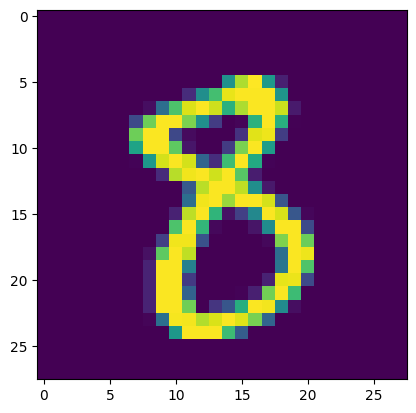

In [7]:
mnist_random(m)

In [8]:
# creating a normalization function

def normalize(data):
    # normalizing along rows because each column may have all zeros, i.e, black pixels in the edges of every image.
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std

    norms = np.linalg.norm(data_normalized, axis = 1)
    max_norm = norms.max()
    data_normalized = data_normalized / max_norm
    return data_normalized


In [9]:
X_norm = normalize(X)

c = 1

# Finding max of l2 norm of design matrix along rows to check if its 1, as it should be after normalization
print(np.linalg.norm(X_norm, axis = 1).max()) # sanity check


1.0


In [10]:
# Code for separating each class into their own separate data
digits = {} # empty dictionary
for i in range(10):
  digits['index '+ str(i)] = np.where(Y == i)[0]
  digits['X ' + str(i)] = X_norm[digits['index '+str(i)],:]
  digits['Y ' + str(i)] = np.ones((digits['X '+str(i)].shape[0],1))

  print(f"The digit {i} has {digits['X '+str(i)].shape[0]} training examples and {digits['X '+str(i)].shape[1]} features: feature vector dimension - {digits['X '+str(i)].shape}")
  print(f"The labels for digit {i} has dimension - {digits['Y '+str(i)].shape}")

The digit 0 has 6903 training examples and 784 features: feature vector dimension - (6903, 784)
The labels for digit 0 has dimension - (6903, 1)
The digit 1 has 7877 training examples and 784 features: feature vector dimension - (7877, 784)
The labels for digit 1 has dimension - (7877, 1)
The digit 2 has 6990 training examples and 784 features: feature vector dimension - (6990, 784)
The labels for digit 2 has dimension - (6990, 1)
The digit 3 has 7141 training examples and 784 features: feature vector dimension - (7141, 784)
The labels for digit 3 has dimension - (7141, 1)
The digit 4 has 6824 training examples and 784 features: feature vector dimension - (6824, 784)
The labels for digit 4 has dimension - (6824, 1)
The digit 5 has 6313 training examples and 784 features: feature vector dimension - (6313, 784)
The labels for digit 5 has dimension - (6313, 1)
The digit 6 has 6876 training examples and 784 features: feature vector dimension - (6876, 784)
The labels for digit 6 has dimensi

In [11]:
print(digits['Y 3'])

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [12]:
# using dig1 and dig2 to decide which digits to perform binary classification on. dig1 -> +ve, dig2 -> -ve

def BinClassData(digits, dig1, dig2):
    x1 = digits['X '+str(dig1)]
    x2 = digits['X '+str(dig2)]

    y1 = digits['Y '+str(dig1)]
    y2 = digits['Y '+str(dig2)] - 1

    X = np.vstack((x1, x2))
    Y = np.vstack((y1, y2))

    return X, Y

In [13]:
# For now, we use 0 vs 6 with 0 as our positive case and 6 as our negative case

X, Y = BinClassData(digits, 0, 6)

m = X.shape[0]
n = X.shape[1]

print(X.shape)
print(Y.shape)

(13779, 784)
(13779, 1)


In [14]:
print(Y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
def visualize(X, Y, k):
    img = np.reshape(X[k,:],(img_size, img_size))
    print(f"The digit shown below is labeled {Y[k]} with index number {k}:")
    plt.imshow(img)

The digit shown below is labeled [0.] with index number 13729:


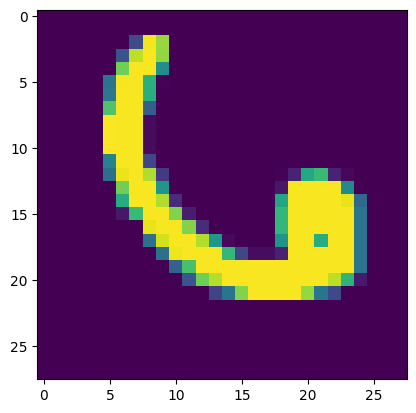

In [ ]:
idx = np.random.randint(m)
visualize(X,Y,idx)

In [ ]:

# Split to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

print(np.sum((Y_train==0).astype(int)))
print(np.sum((Y_test==0).astype(int)))

The shape of the training set feature matrix is: (11023, 784)
The shape of the training label vector is: (11023, 1)
The shape of the test set feature matrix is: (2756, 784)
The shape of the test label vector is: (2756, 1)
5502
1374


In [ ]:
print(Y_test)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
# Concatenating X with a column of ones
def concatenator(X):
    m = X.shape[0]
    arb = np.hstack((np.ones([m,1]),X))
    print(f"The data now has a column of ones in front. It went from dimensions {X.shape} to {arb.shape}")
    return arb

In [ ]:
X_train_n = concatenator(X_train)
X_test_n = concatenator(X_test)

print(X_train_n.shape)
print(X_test_n.shape)


The data now has a column of ones in front. It went from dimensions (11023, 784) to (11023, 785)
The data now has a column of ones in front. It went from dimensions (2756, 784) to (2756, 785)
(11023, 785)
(2756, 785)


In [ ]:
# Gradient initializer
def initializer(n):
    theta = np.zeros((n,1))
    return theta

# Implementation of sigmoid function
def sig(z):
    return 1/(1+np.exp(-z))

# Implementation of hypothesis
def hypothesis(X, theta):
    h = np.matmul(X, theta)
    return sig(h)

# Implementation of cost function
def cost(X, Y, theta, lam):
    m = X.shape[0]
    h = hypothesis(X, theta)
    J1 = -np.matmul(Y.T, np.log(h))
    J2 = -np.matmul((1-Y).T, np.log(1-h))
    J = (J1 + J2) / m + (lam / (2*m)) * np.dot(theta.T, theta)
    J = J.item()
    return J

# Gradient Calculations
def grad(X, Y, theta, lam):
    m = X.shape[0]
    n = X.shape[1]
    h = hypothesis(X, theta)
    dtheta = np.matmul(X.T, (h-Y)) / m

    arb = np.zeros((n,1))
    arb[1:] = theta[1:]
    dtheta = dtheta + (lam / m) * arb
    return dtheta

In [ ]:
# Create prediction function

def predict(X, theta):
    Yhat_prob = sig(np.matmul(X, theta))
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

In [ ]:
# Create prediction function, this is for

def predictor(X, theta):
    Yhat_prob = sig(theta[0] + np.dot(X, theta[1:]))
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

In [ ]:
# Creating the gradient descent optimizer function

def gradient_descent(X, Y, X_test, Y_test, theta, alpha, epoch, batch_size, lam):

    i=0
    RMSE = 1
    m = X.shape[0]
    # batch size when given equal to -1, will do batch gradient descent instead of mini batch
    if batch_size == -1:
        batch_size = m

    blocks = np.ceil(m / batch_size).astype('int')

    cost_history=[]
    test_acc_history = []
    train_acc_history = []

    J = cost(X, Y, theta, lam)

    cost_history.append(J)

    Yhat, _ = predict(X, theta)
    train_accuracy = accuracy_score(Y, Yhat)
    train_acc_history.append(train_accuracy)

    Yhat, _ = predict(X_test, theta)
    test_accuracy = accuracy_score(Y_test, Yhat)
    test_acc_history.append(test_accuracy)

    for i in range(epoch):
        if i % 500 == 0:
            print(f"iteration number {i} / {epoch}, Cost: {J}, Train Acc: {train_accuracy * 100}, Test Acc: {test_accuracy * 100}")
        for k in range(blocks):
            # print(f"Block count: {k*batch_size} / {m}")

            if (k+1) == blocks:
                X_curr = X[(k*batch_size):,:]
                Y_curr = Y[(k*batch_size):,:]
            else:
                X_curr = X[(k*batch_size):((k+1)*batch_size),:]
                Y_curr = Y[(k*batch_size):((k+1)*batch_size),:]

            J = cost(X_curr, Y_curr, theta, lam)
            dtheta = grad(X_curr, Y_curr, theta, lam)
            theta = theta - alpha * dtheta

            cost_history.append(J)

            Yhat, _ = predict(X, theta)
            train_accuracy = accuracy_score(Y, Yhat)
            train_acc_history.append(train_accuracy)

            Yhat, _ = predict(X_test, theta)
            test_accuracy = accuracy_score(Y_test, Yhat)
            test_acc_history.append(test_accuracy)


    return cost_history, train_acc_history, test_acc_history, theta, i

In [ ]:
def LogRegModel(X_train, Y_train, X_test, Y_test, alpha, epoch, batch_size, lam):

    n = X_train.shape[1]
    theta = initializer(n)
    cost_history, train_acc_history, test_acc_history, theta, i = gradient_descent(X_train, Y_train, X_test, Y_test, theta, alpha, epoch, batch_size, lam)
    Yhat_train, _ = predict(X_train, theta)
    Yhat, _ = predict(X_test, theta)

    train_acc = accuracy_score(Y_train, Yhat_train)
    test_acc = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize = None)

    model = {'weights': theta,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'confusion_matrix': conf_matrix,
            'cost_history': cost_history,
             'train_history': train_acc_history,
             'test_history': test_acc_history}
    return model

Progress bar: 1 step each 50 iteration
iteration number 0 / 2000, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 2000, Cost: 0.11567176304485366, Train Acc: 97.81366234237503, Test Acc: 97.56894049346879
iteration number 1000 / 2000, Cost: 0.08194385945812131, Train Acc: 98.19468384287399, Test Acc: 98.14949201741655
iteration number 1500 / 2000, Cost: 0.06781540122501495, Train Acc: 98.43055429556382, Test Acc: 98.43976777939042
Training completed!
[[1354   20]
 [  19 1363]]
Train accuracy: 98.61199310532523 %, Test accuracy: 98.58490566037736 %


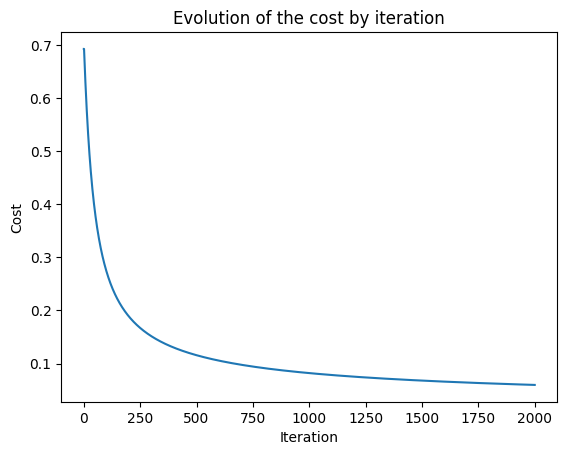

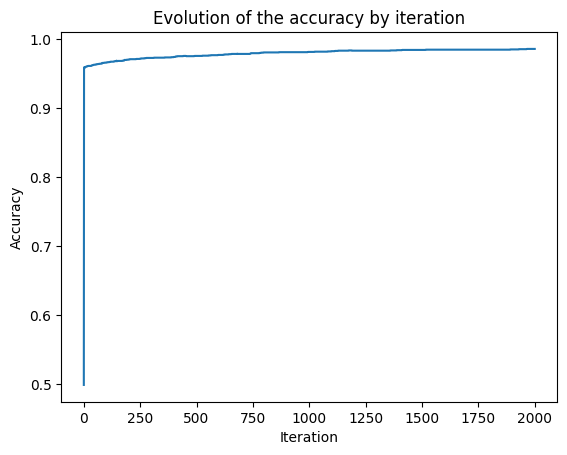

Total time elapsed: 70.99182629585266


In [ ]:
# Testing the model function by training a classifier for the digit '0'
import time

start = time.time()
l = 0
alpha = 0.5
epoch = 2000
batch_size = -1

print('Progress bar: 1 step each 50 iteration')
model = LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha, epoch, batch_size, l)
print('Training completed!')

print(model['confusion_matrix'])
print(f"Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

plt.figure()
cost_values = model['cost_history']
plt.plot(list(range(len(cost_values))),cost_values)
plt.title('Evolution of the cost by iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost');
plt.show()

plt.figure()
test_acc_values = model['test_history']
train_acc_values = model['train_history']
plt.plot(list(range(len(test_acc_values))),test_acc_values)
plt.title('Evolution of the accuracy by iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy');
plt.show()

end = time.time()

print(f"Total time elapsed: {end - start}")



In [ ]:

# Creating a function that shows a random image with the true and predicted label

def check_random_pred(datum,Y,model,label):
    theta = model['weights']
    Yhat, _ = predictor(datum,theta)
    if Yhat == 1:
        pred_label = label
    else:
        pred_label = 'Not '+ label
    if Y == 1:
        true_label = label
    else:
        true_label = 'Not '+ label
    print("The number in the image below is:", true_label, ' and predicted as:', pred_label)
    image = datum.reshape(img_size,img_size)
    plt.imshow(image)

Index number: 1629
The number in the image below is: Not 0  and predicted as: Not 0


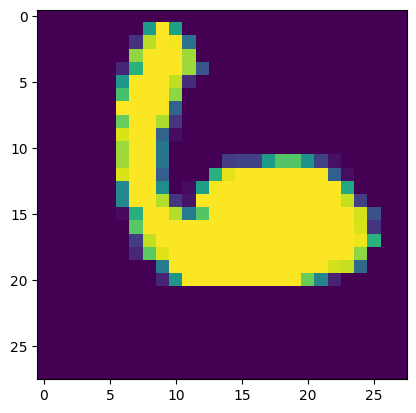

In [ ]:
# Checking some random image predictions

idx = np.random.randint(X_test.shape[0])
datum = X_test[idx]
Y = Y_test[idx]
print(f"Index number: {idx}")
check_random_pred(datum,Y,model, '0')

In [ ]:
# Implementing Gaussian Mechanism in GD of Logistic Regression

def sensitivity_calc(epsilon, delta, delta_cap):
    sigma = (delta_cap / epsilon) * np.sqrt(2 * np.log(1.25 / delta))
    return sigma

In [ ]:
# Creating the gradient descent optimizer function

def DP_gradient_descent(X, Y, X_test, Y_test, theta, alpha, epoch, batch_size, lam, sigma):

    i=0
    RMSE = 1
    m = X.shape[0]
    n = X.shape[1]
    # batch size when given equal to -1, will do batch gradient descent instead of mini batch
    if batch_size == -1:
        batch_size = m

    blocks = np.ceil(m / batch_size).astype('int')

    cost_history=[]
    test_acc_history = []
    train_acc_history = []

    J = cost(X, Y, theta, lam)

    cost_history.append(J)

    Yhat, _ = predict(X, theta)
    train_accuracy = accuracy_score(Y, Yhat)
    train_acc_history.append(train_accuracy)

    Yhat, _ = predict(X_test, theta)
    test_accuracy = accuracy_score(Y_test, Yhat)
    test_acc_history.append(test_accuracy)

    for i in range(epoch):
        if i % 500 == 0:
            print(f"iteration number {i} / {epoch}, Cost: {J}, Train Acc: {train_accuracy * 100}, Test Acc: {test_accuracy * 100}")
            # if J > cost_history[0]:
            #     print(f"Cost diverges: {cost_history[0]} -> J")
            #     break
        for k in range(blocks):
            # print(f"Block count: {k*batch_size} / {m}")

            if (k+1) == blocks:
                X_curr = X[(k*batch_size):,:]
                Y_curr = Y[(k*batch_size):,:]
            else:
                X_curr = X[(k*batch_size):((k+1)*batch_size),:]
                Y_curr = Y[(k*batch_size):((k+1)*batch_size),:]

            J = cost(X_curr, Y_curr, theta, lam)
            dtheta = grad(X_curr, Y_curr, theta, lam) + np.random.normal(0, sigma, (n,1))
            theta = theta - alpha * dtheta

            cost_history.append(J)

            Yhat, _ = predict(X, theta)
            train_accuracy = accuracy_score(Y, Yhat)
            train_acc_history.append(train_accuracy)

            Yhat, _ = predict(X_test, theta)
            test_accuracy = accuracy_score(Y_test, Yhat)
            test_acc_history.append(test_accuracy)


    return cost_history, train_acc_history, test_acc_history, theta, i

def DP_LogRegModel(X_train, Y_train, X_test, Y_test, alpha, epoch, batch_size, lam, sigma):

    n = X_train.shape[1]
    theta = initializer(n)
    cost_history, train_acc_history, test_acc_history, theta, i = DP_gradient_descent(X_train, Y_train, X_test, Y_test, theta, alpha, epoch, batch_size, lam, sigma)
    Yhat_train, _ = predict(X_train, theta)
    Yhat, _ = predict(X_test, theta)

    train_acc = accuracy_score(Y_train, Yhat_train)
    test_acc = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize = None)

    model = {'weights': theta,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'confusion_matrix': conf_matrix,
            'cost_history': cost_history,
             'train_history': train_acc_history,
             'test_history': test_acc_history}
    return model

In [ ]:
epsilon = 0.0001
delta = 1e-5
m_train = X_train.shape[0]
print(m_train, c)
delta_cap = (2 * c) / m_train

sigma = sensitivity_calc(epsilon, delta, delta_cap)
print(f"Epsilon: {epsilon}, delta: {delta}, Capital delta: {delta_cap}, sigma: {sigma}")

11023 1
Epsilon: 0.0001, delta: 1e-05, Capital delta: 0.00018143880976140796, sigma: 8.790357003729273


In [ ]:
print(len(model['cost_history']))

2001


In [ ]:
len(model['cost_history'])

2001

In [ ]:
# Testing the model function by training a classifier for the digit '0'

l = 0
alpha = 0.01
epoch = 5000
batch_size = -1
if batch_size == -1:
    iterations = epoch + 1 # There is an extra entry included initially

else:
    blocks = ceil(X_train_n.shape[0] / batch_size)
    iterations = blocks * epoch + 1 # There is an extra entry included initially

runs = 10
cost_history_avg = np.zeros((runs, iterations))
test_history_avg = np.zeros((runs, iterations))
train_history_avg = np.zeros((runs, iterations))


for i in range(runs):

    print(f"Run number: {i} out of {runs}")
    print('Progress bar: 1 step each 50 iteration')
    model = DP_LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha, epoch, batch_size, l, sigma)
    print('Training completed!')

    print(model['confusion_matrix'])
    print(f"Final cost: {model['cost_history'][-1]}Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

    arb = iterations - len(model['cost_history'])

    cost_history_avg[i,:] = np.hstack((model['cost_history'], np.zeros((arb,))))
    test_history_avg[i,:] = np.hstack((model['test_history'], np.zeros((arb,))))
    train_history_avg[i,:] = np.hstack((model['train_history'], np.zeros((arb,))))

    plt.figure()
    cost_values = model['cost_history']
    plt.plot(list(range(len(cost_values))),cost_values)
    plt.title('Evolution of the cost by iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost');
    plt.show()

    plt.figure()
    train_acc_values = model['train_history']
    test_acc_values = model['test_history']

    plt.plot(list(range(len(train_acc_values))),train_acc_values, test_acc_values)
    plt.legend(['train accuracy', 'test accuracy'])
    plt.title('Evolution of the accuracy by iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy');
    plt.show()

cost_history_avg = np.mean(cost_history_avg, axis = 0)
test_history_avg = np.mean(test_history_avg, axis = 0)
train_history_avg = np.mean(train_history_avg, axis = 0)

plt.figure()
plt.plot(list(range(len(cost_history_avg))),cost_history_avg)
plt.title('Evolution of the cost by iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost');
plt.show()


plt.figure()
plt.plot(list(range(len(test_history_avg))), train_history_avg, test_history_avg)
plt.legend(['train accuracy','test accuracy'])
plt.title('Evolution of the accuracy by iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy');
plt.show()

final_cost = cost_history_avg[-1]
final_train_acc = train_history_avg[-1]
final_test_acc = test_history_avg[-1]




NameError: name 'np' is not defined

In [ ]:
epsilon = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.99])
delta = 1e-5
m_train = X_train.shape[0]
print(m_train, c)
delta_cap = (2 * c) / m_train

sigma = sensitivity_calc(epsilon, delta, delta_cap)
print(f"Epsilon: {epsilon}, delta: {delta}, Capital delta: {delta_cap}, sigma: {sigma}")

11023 1
Epsilon: [1.0e-04 5.0e-04 1.0e-03 5.0e-03 1.0e-02 5.0e-02 1.0e-01 5.0e-01 9.0e-01
 9.9e-01], delta: 1e-05, Capital delta: 0.00018143880976140796, sigma: [8.79035700e+00 1.75807140e+00 8.79035700e-01 1.75807140e-01
 8.79035700e-02 1.75807140e-02 8.79035700e-03 1.75807140e-03
 9.76706334e-04 8.87914849e-04]


In [ ]:
import time
from copy import copy

epsilon = np.array([0.9, 0.8, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
delta = 1e-5
delta_cap = (2 * c) / m_train

l = 0
alpha = np.array([0.5, 0.3, 0.1, 0.06, 0.03, 0.01, 0.005, 0.001])
epoch = 2000
batch_size = -1

if batch_size == -1:
    iterations = epoch # There is an extra entry included initially

else:
    blocks = ceil(X_train_n.shape[0] / batch_size)
    iterations = blocks * epoch + 1 # There is an extra entry included initially

runs = 10

Histories_wrt_epsilon = {}

All_models = {}
for eps in epsilon:
    k = 0
    sigma = sensitivity_calc(eps, delta, delta_cap)
    print(f"Currently running for epsilon: {eps}, sigma: {sigma}")


    cost_hist = np.zeros((len(alpha), iterations+1))
    test_hist = np.zeros((len(alpha), iterations+1))
    train_hist = np.zeros((len(alpha), iterations+1))

    for j in range(len(alpha)):

        start = time.time()

        cost_history_avg = np.zeros((runs, iterations+1))
        test_history_avg = np.zeros((runs, iterations+1))
        train_history_avg = np.zeros((runs, iterations+1))



        print(f"Currently running for epsilon: {eps}, sigma: {sigma}")
        print(f"learning rate number: {j}, learning rate: {alpha[j]}")

        for i in range(runs):

            print(f"Run number: {i+1} out of {runs}")
            model = DP_LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha[j], epoch, batch_size, l, sigma)
            print('Training completed!')

            All_models[str(k) + '_' + str(j) + '_' + str(i)] = model
            print(model['confusion_matrix'])
            print(f"Final cost: {model['cost_history'][-1]} Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

            cost_history_avg[i,:] = copy(np.array(model['cost_history']))
            test_history_avg[i,:] = copy(np.array(model['test_history']))
            train_history_avg[i,:] = copy(np.array(model['train_history']))

            # plt.figure()
            # cost_values = model['cost_history']
            # plt.plot(list(range(len(cost_values))),cost_values)
            # plt.title('Evolution of the cost by iteration')
            # plt.xlabel('Iteration')
            # plt.ylabel('Cost');
            # plt.show()

            # plt.figure()
            # train_acc_values = model['train_history']
            # test_acc_values = model['test_history']

            # plt.plot(list(range(len(train_acc_values))),train_acc_values, test_acc_values)
            # plt.legend(['train accuracy', 'test accuracy'])
            # plt.title('Evolution of the accuracy by iteration')
            # plt.xlabel('Iteration')
            # plt.ylabel('Accuracy');
            # plt.show()

        cost_history_avg = np.mean(cost_history_avg, axis = 0)
        test_history_avg = np.mean(test_history_avg, axis = 0)
        train_history_avg = np.mean(train_history_avg, axis = 0)

        cost_hist[j,:] = copy(cost_history_avg)
        test_hist[j,:] = copy(test_history_avg)
        train_hist[j,:] = copy(train_history_avg)

        plt.figure()
        plt.plot(list(range(len(cost_hist[j,:]))),cost_hist[j,:])
        plt.title('Evolution of the cost by iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Cost');
        plt.show()


        plt.figure()
        plt.plot(list(range(len(test_hist[j,:]))), train_hist[j,:], test_hist[j,:])
        plt.legend(['train accuracy','test accuracy'])
        plt.title('Evolution of the accuracy by iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy');
        plt.show()

        end = time.time()


        print(f"Time taken for one epsilon and one learning rate: {end - start}")

    Histories_wrt_epsilon['cost ' + str(eps)] = copy(cost_hist)
    Histories_wrt_epsilon['test ' + str(eps)] = copy(test_hist)
    Histories_wrt_epsilon['train ' + str(eps)] = copy(train_hist)

    k = k + 1

    savemat('epsilon cost ' + str(eps), {"array": cost_hist})
    savemat('epsilon test ' + str(eps), {"array": test_hist})
    savemat('epsilon train ' + str(eps), {"array": train_hist})



savemat('Data All', {"Model infos": Histories_wrt_epsilon, "All models": All_models})




In [ ]:
savemat('Data All', {"Model infos": Histories_wrt_epsilon, "All models": All_models})

In [ ]:
print(Histories_wrt_epsilon['cost 0.9'])

NameError: name 'Histories_wrt_epsilon' is not defined

Currently running for epsilon: 0.9, sigma: 0.000976706333747697, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.11588875409578386, Train Acc: 97.81366234237503, Test Acc: 97.56894049346879
iteration number 1000 / 3500, Cost: 0.08201293449821485, Train Acc: 98.20375578336206, Test Acc: 98.11320754716981
iteration number 1500 / 3500, Cost: 0.06785607156261025, Train Acc: 98.4396262360519, Test Acc: 98.43976777939042
iteration number 2000 / 3500, Cost: 0.05967492452328001, Train Acc: 98.61199310532523, Test Acc: 98.58490566037736
iteration number 2500 / 3500, Cost: 0.054290044486100086, Train Acc: 98.70271251020594, Test Acc: 98.58490566037736
iteration number 3000 / 3500, Cost: 0.0503268947484992, Train Acc: 98.75714415313436, Test Acc: 98.65747460087083
Training completed!
[[1356   18]
 [  18 1364]]
Final cost: 0.047371441085941345 Train accura

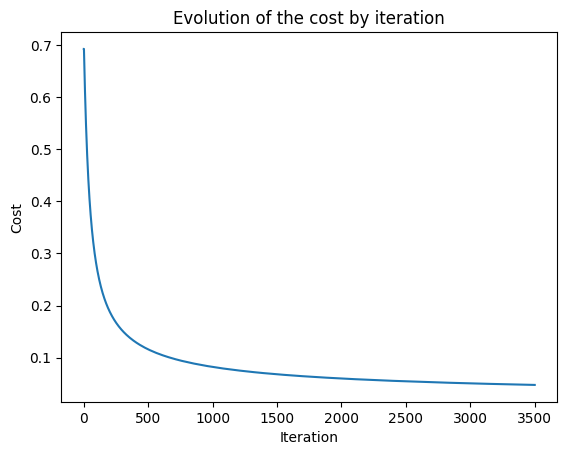

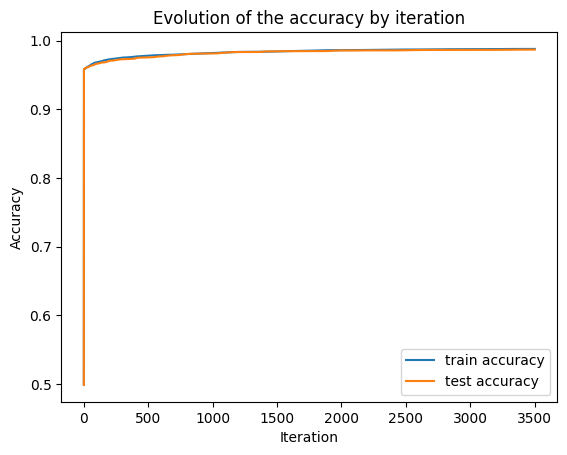

Currently running for epsilon: 0.8, sigma: 0.001098794625466159, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.11564696845780247, Train Acc: 97.81366234237503, Test Acc: 97.53265602322206
iteration number 1000 / 3500, Cost: 0.08187374817448768, Train Acc: 98.20375578336206, Test Acc: 98.11320754716981
iteration number 1500 / 3500, Cost: 0.06787398480708653, Train Acc: 98.44869817653996, Test Acc: 98.4034833091437
iteration number 2000 / 3500, Cost: 0.05969919482207438, Train Acc: 98.61199310532523, Test Acc: 98.54862119013063
iteration number 2500 / 3500, Cost: 0.054273106128710176, Train Acc: 98.69364056971787, Test Acc: 98.58490566037736
iteration number 3000 / 3500, Cost: 0.05036500425918767, Train Acc: 98.75714415313436, Test Acc: 98.65747460087083
Training completed!
[[1356   18]
 [  18 1364]]
Final cost: 0.04735791099493908 Train accura

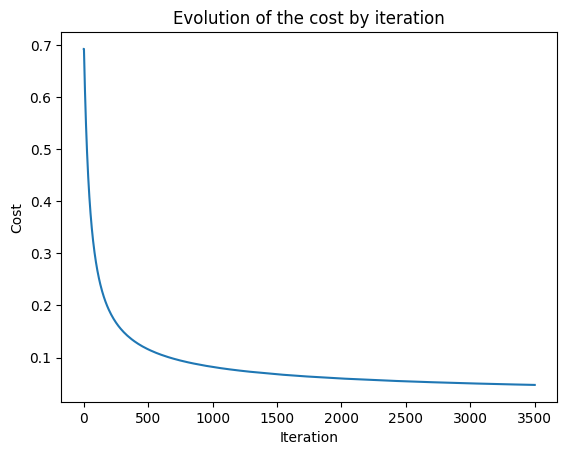

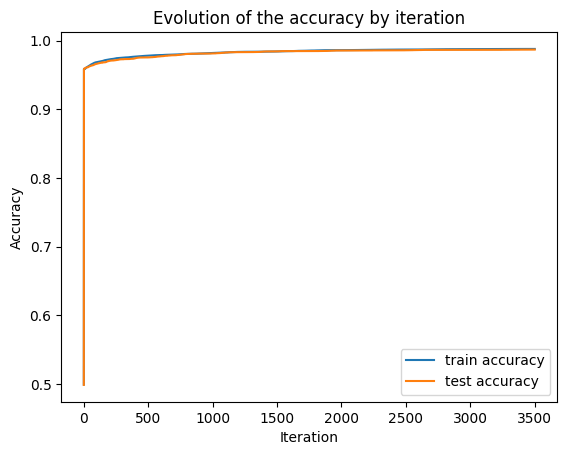

Currently running for epsilon: 0.5, sigma: 0.0017580714007458546, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.11568778928055548, Train Acc: 97.8227342828631, Test Acc: 97.56894049346879
iteration number 1000 / 3500, Cost: 0.081939128280779, Train Acc: 98.21282772385013, Test Acc: 98.14949201741655
iteration number 1500 / 3500, Cost: 0.06797552786819917, Train Acc: 98.4668420575161, Test Acc: 98.4034833091437
iteration number 2000 / 3500, Cost: 0.05970919920315665, Train Acc: 98.61199310532523, Test Acc: 98.51233671988389
iteration number 2500 / 3500, Cost: 0.05427178660335477, Train Acc: 98.71178445069401, Test Acc: 98.58490566037736
iteration number 3000 / 3500, Cost: 0.05031028224117418, Train Acc: 98.75714415313436, Test Acc: 98.65747460087083
Training completed!
[[1356   18]
 [  18 1364]]
Final cost: 0.04725553113313424 Train accuracy: 

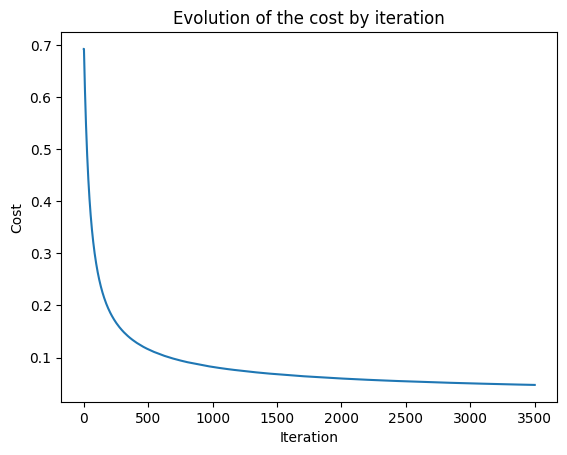

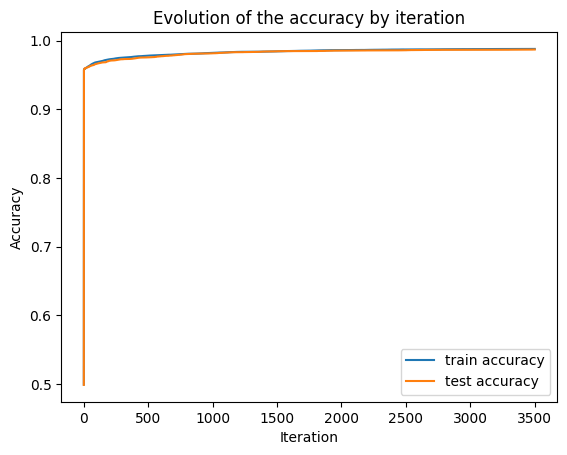

Currently running for epsilon: 0.1, sigma: 0.008790357003729272, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.11357695891210993, Train Acc: 97.8862378662796, Test Acc: 97.75036284470247
iteration number 1000 / 3500, Cost: 0.08029806183697054, Train Acc: 98.3761226526354, Test Acc: 98.25834542815674
iteration number 1500 / 3500, Cost: 0.06674963556958596, Train Acc: 98.53941758142066, Test Acc: 98.36719883889695
iteration number 2000 / 3500, Cost: 0.05781063666280505, Train Acc: 98.69364056971787, Test Acc: 98.54862119013063
iteration number 2500 / 3500, Cost: 0.05318722716558825, Train Acc: 98.79343191508664, Test Acc: 98.62119013062409
iteration number 3000 / 3500, Cost: 0.04930239225484344, Train Acc: 98.81157579606278, Test Acc: 98.69375907111755
Training completed!
[[1358   16]
 [  17 1365]]
Final cost: 0.04647748180130044 Train accuracy

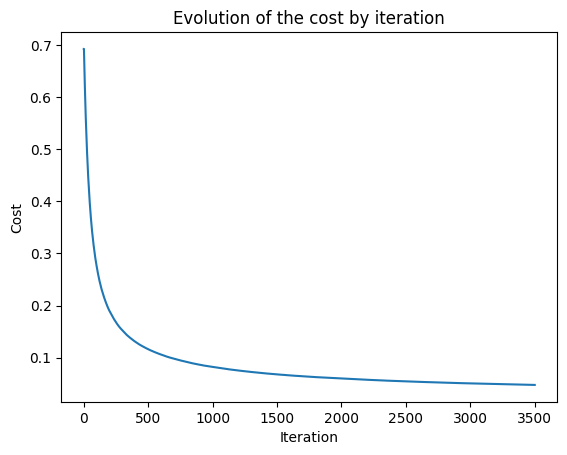

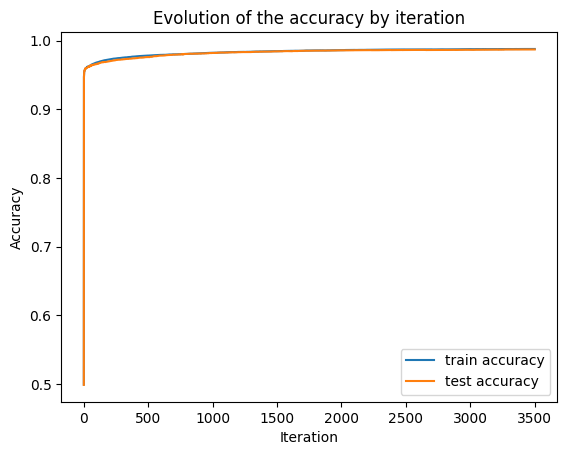

Currently running for epsilon: 0.05, sigma: 0.017580714007458545, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.11603161665121267, Train Acc: 97.8499501043273, Test Acc: 97.60522496371553
iteration number 1000 / 3500, Cost: 0.0834286292819091, Train Acc: 98.18561190238592, Test Acc: 98.07692307692307
iteration number 1500 / 3500, Cost: 0.06780525302045841, Train Acc: 98.4668420575161, Test Acc: 98.43976777939042
iteration number 2000 / 3500, Cost: 0.06007728315156976, Train Acc: 98.59384922434909, Test Acc: 98.51233671988389
iteration number 2500 / 3500, Cost: 0.055247609651053776, Train Acc: 98.67549668874173, Test Acc: 98.47605224963716
iteration number 3000 / 3500, Cost: 0.050971108991103936, Train Acc: 98.67549668874173, Test Acc: 98.47605224963716
Training completed!
[[1353   21]
 [  20 1362]]
Final cost: 0.04875430381023656 Train accura

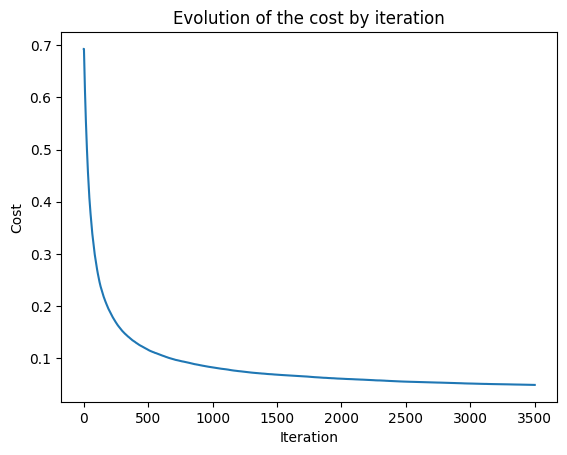

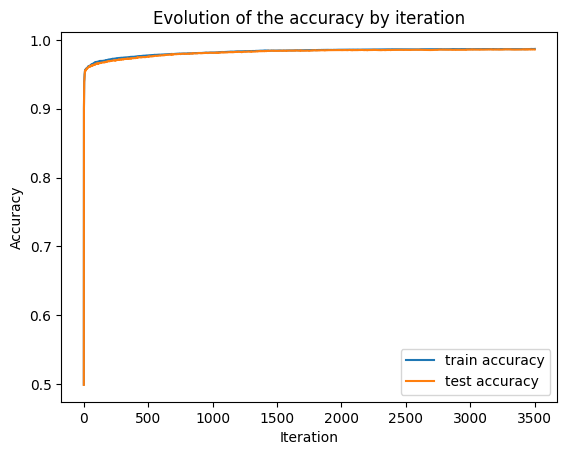

Currently running for epsilon: 0.01, sigma: 0.08790357003729272, learning rate: 0.5
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.12168383815318908, Train Acc: 96.40751156672412, Test Acc: 96.11756168359942
iteration number 1000 / 3500, Cost: 0.08232994990200874, Train Acc: 97.52336024675678, Test Acc: 97.53265602322206
iteration number 1500 / 3500, Cost: 0.07623635173481595, Train Acc: 97.6685112945659, Test Acc: 97.85921625544267
iteration number 2000 / 3500, Cost: 0.06746888176699863, Train Acc: 98.04046085457679, Test Acc: 98.04063860667634
iteration number 2500 / 3500, Cost: 0.0699247401322096, Train Acc: 97.9769572711603, Test Acc: 97.677793904209
iteration number 3000 / 3500, Cost: 0.06456259139766186, Train Acc: 98.01324503311258, Test Acc: 97.8955007256894
Training completed!
[[1342   32]
 [  16 1366]]
Final cost: 0.054971269954424855 Train accuracy: 9

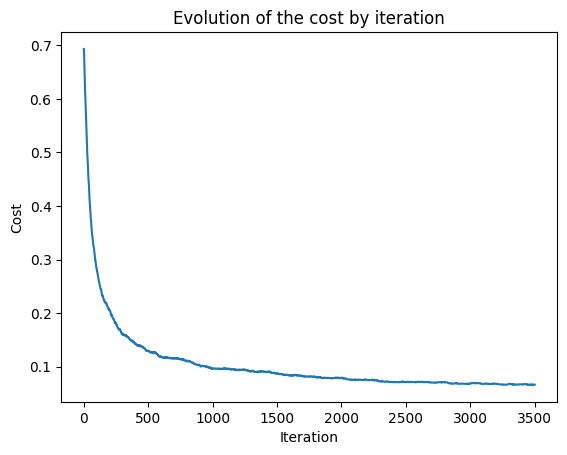

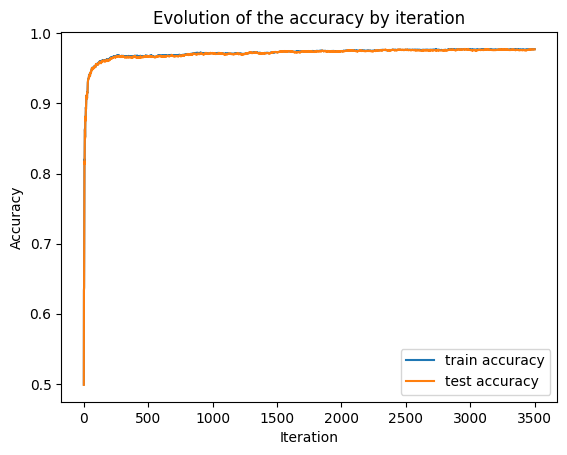

Currently running for epsilon: 0.005, sigma: 0.17580714007458545, learning rate: 0.3
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.1798098131312799, Train Acc: 95.40052617254831, Test Acc: 95.50072568940493
iteration number 1000 / 3500, Cost: 0.13802088269330715, Train Acc: 95.45495781547673, Test Acc: 95.93613933236574
iteration number 1500 / 3500, Cost: 0.12982721305338477, Train Acc: 95.32795064864375, Test Acc: 95.97242380261248
iteration number 2000 / 3500, Cost: 0.12621368157507118, Train Acc: 95.35516647010796, Test Acc: 95.89985486211901
iteration number 2500 / 3500, Cost: 0.09710037387302815, Train Acc: 96.5980223169736, Test Acc: 96.77068214804065
iteration number 3000 / 3500, Cost: 0.08520326402251789, Train Acc: 97.09697904381748, Test Acc: 97.27866473149493
Training completed!
[[1346   28]
 [  56 1326]]
Final cost: 0.08968157785399848 Train accurac

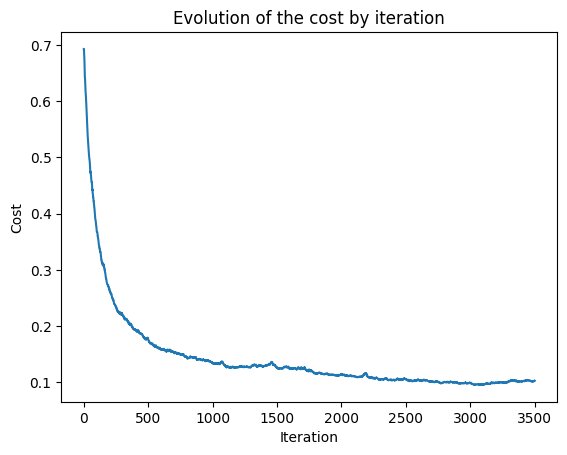

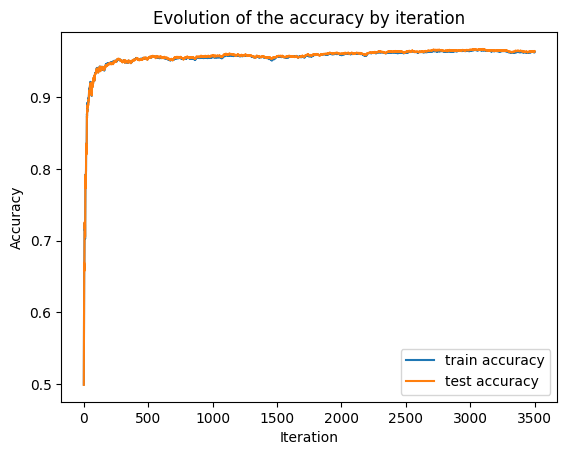

Currently running for epsilon: 0.001, sigma: 0.8790357003729272, learning rate: 0.03
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.45193217239299843, Train Acc: 89.00480812845868, Test Acc: 88.6066763425254
iteration number 1000 / 3500, Cost: 0.3890625556753497, Train Acc: 90.33838338020502, Test Acc: 90.38461538461539
iteration number 1500 / 3500, Cost: 0.3340560965562987, Train Acc: 92.02576431098612, Test Acc: 91.69085631349783
iteration number 2000 / 3500, Cost: 0.3100223545341174, Train Acc: 91.67195863195138, Test Acc: 91.43686502177069
iteration number 2500 / 3500, Cost: 0.2795285839834144, Train Acc: 91.29093713145242, Test Acc: 90.4934687953556
iteration number 3000 / 3500, Cost: 0.22348699455513796, Train Acc: 94.65662705252653, Test Acc: 94.26705370101597
Training completed!
[[1289   85]
 [  96 1286]]
Final cost: 0.2142975297437506 Train accuracy: 94

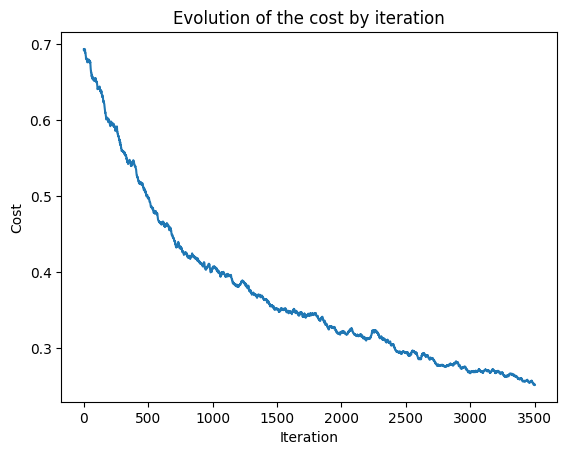

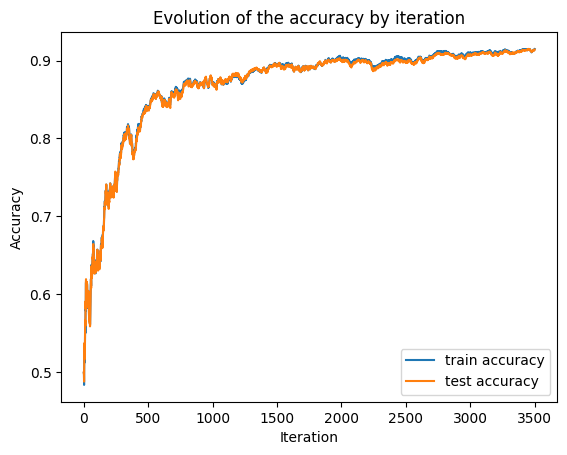

Currently running for epsilon: 0.0005, sigma: 1.7580714007458544, learning rate: 0.015
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.6079606510869521, Train Acc: 69.03746711421573, Test Acc: 68.10595065312046
iteration number 1000 / 3500, Cost: 0.5697219404729036, Train Acc: 72.27614986845687, Test Acc: 71.00870827285921
iteration number 1500 / 3500, Cost: 0.5695148385773215, Train Acc: 70.55248117572349, Test Acc: 69.81132075471697
iteration number 2000 / 3500, Cost: 0.5582518717144985, Train Acc: 70.38918624693822, Test Acc: 70.21044992743106
iteration number 2500 / 3500, Cost: 0.4883934321474396, Train Acc: 76.57624965980223, Test Acc: 76.52394775036284
iteration number 3000 / 3500, Cost: 0.41970942506932263, Train Acc: 80.92170915358795, Test Acc: 80.91436865021771
Training completed!
[[1179  195]
 [ 284 1098]]
Final cost: 0.41318028506593285 Train accuracy

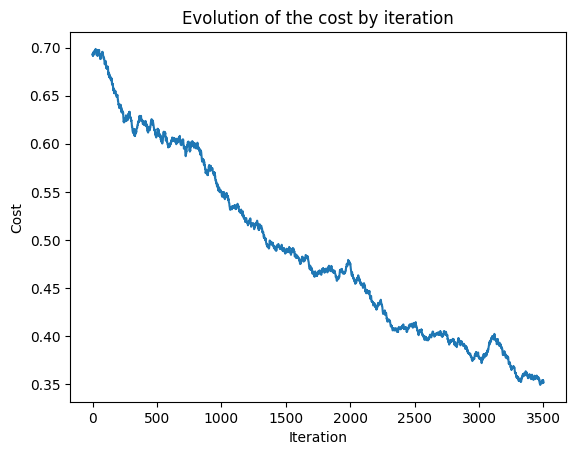

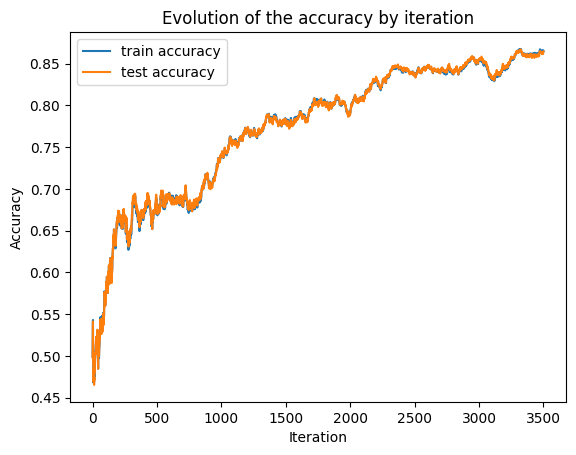

Currently running for epsilon: 0.0001, sigma: 8.790357003729273, learning rate: 0.002
Run number: 1 out of 10
iteration number 0 / 3500, Cost: 0.6931471805599463, Train Acc: 49.913816565363334, Test Acc: 49.85486211901306
iteration number 500 / 3500, Cost: 0.8122048311260838, Train Acc: 50.022679851220175, Test Acc: 50.14513788098694
iteration number 1000 / 3500, Cost: 0.8548645924275929, Train Acc: 43.94447972421301, Test Acc: 44.44847605224964
iteration number 1500 / 3500, Cost: 0.7965711989137598, Train Acc: 50.294838065862294, Test Acc: 51.088534107402026
iteration number 2000 / 3500, Cost: 0.8704796978174578, Train Acc: 49.795881339018415, Test Acc: 51.01596516690856
iteration number 2500 / 3500, Cost: 0.8000818042322985, Train Acc: 51.8552118298104, Test Acc: 52.64876632801161
iteration number 3000 / 3500, Cost: 0.772707309994662, Train Acc: 52.55375124739182, Test Acc: 53.84615384615385
Training completed!
[[ 311 1063]
 [ 348 1034]]
Final cost: 0.8654487770651461 Train accuracy:

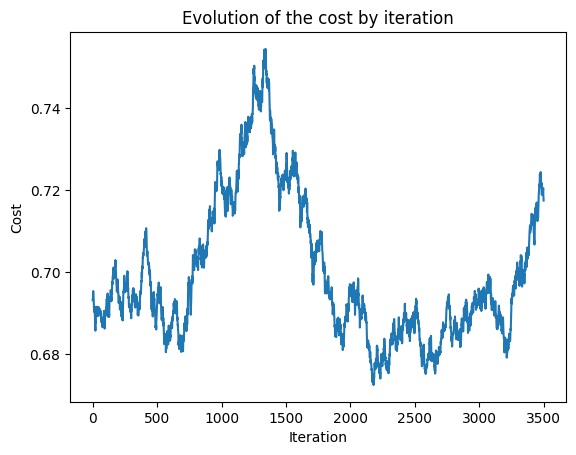

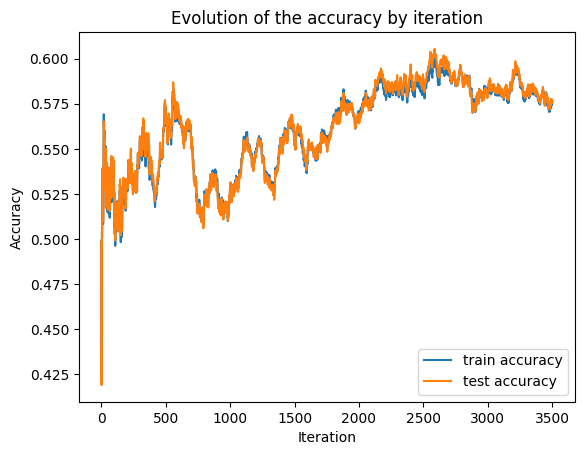

NameError: name 'Histories_wrt_epsilon' is not defined

In [ ]:
import time
from copy import copy

epsilon = np.array([0.9, 0.8, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
delta = 1e-5
delta_cap = (2 * c) / m_train

l = 0
alpha = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.03, 0.015, 0.002])
epoch = 3500
batch_size = -1

if batch_size == -1:
    iterations = epoch # There is an extra entry included initially

else:
    blocks = ceil(X_train_n.shape[0] / batch_size)
    iterations = blocks * epoch + 1 # There is an extra entry included initially

runs = 10

cost_hist = np.zeros((len(alpha), iterations+1))
test_hist = np.zeros((len(alpha), iterations+1))
train_hist = np.zeros((len(alpha), iterations+1))

All_models = {}
for j in range(len(epsilon)):
    k = 0
    sigma = sensitivity_calc(epsilon[j], delta, delta_cap)
    print(f"Currently running for epsilon: {epsilon[j]}, sigma: {sigma}, learning rate: {alpha[j]}")

    cost_history_avg = np.zeros((runs, iterations+1))
    test_history_avg = np.zeros((runs, iterations+1))
    train_history_avg = np.zeros((runs, iterations+1))

    for i in range(runs):

        print(f"Run number: {i+1} out of {runs}")
        model = DP_LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha[j], epoch, batch_size, l, sigma)
        print('Training completed!')

        All_models[str(j) + str(i)] = model
        print(model['confusion_matrix'])
        print(f"Final cost: {model['cost_history'][-1]} Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

        cost_history_avg[i,:] = copy(np.array(model['cost_history']))
        test_history_avg[i,:] = copy(np.array(model['test_history']))
        train_history_avg[i,:] = copy(np.array(model['train_history']))

    cost_history_avg = np.mean(cost_history_avg, axis = 0)
    test_history_avg = np.mean(test_history_avg, axis = 0)
    train_history_avg = np.mean(train_history_avg, axis = 0)

    cost_hist[j,:] = copy(cost_history_avg)
    test_hist[j,:] = copy(test_history_avg)
    train_hist[j,:] = copy(train_history_avg)

    plt.figure()
    plt.plot(list(range(len(cost_hist[j,:]))),cost_hist[j,:])
    plt.title('Evolution of the cost by iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost');
    plt.show()


    plt.figure()
    plt.plot(list(range(len(test_hist[j,:]))), train_hist[j,:], test_hist[j,:])
    plt.legend(['train accuracy','test accuracy'])
    plt.title('Evolution of the accuracy by iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy');
    plt.show()

# savemat('Data All', {"Model infos": Histories_wrt_epsilon, "All models": All_models})




Text(0, 0.5, 'Cost')

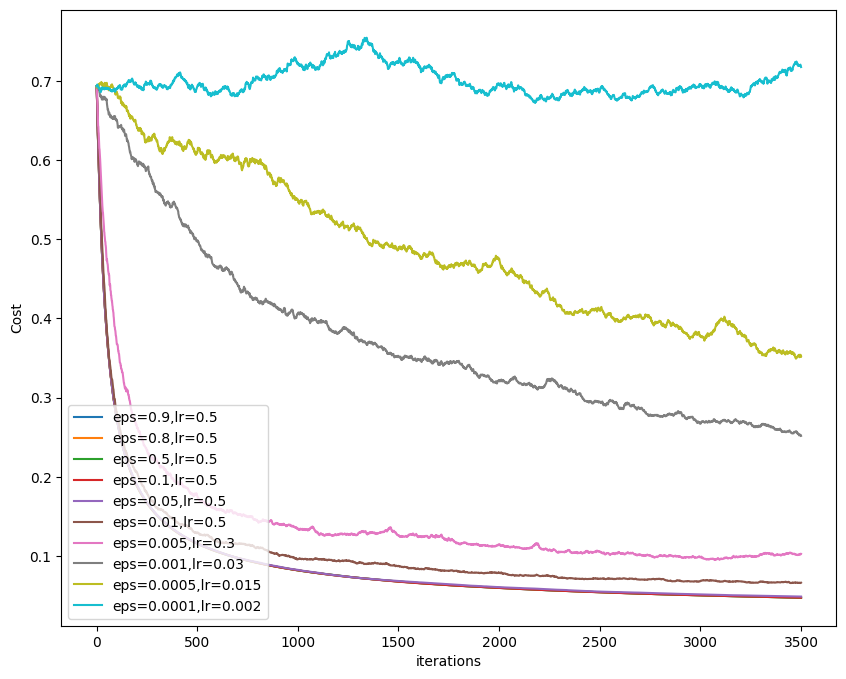

In [ ]:
plt.figure(figsize=(10,8))
for i in range(10):

    plt.plot(cost_hist[i,:])
    plt.legend(['eps=0.9,lr=0.5','eps=0.8,lr=0.5','eps=0.5,lr=0.5','eps=0.1,lr=0.5','eps=0.05,lr=0.5','eps=0.01,lr=0.5','eps=0.005,lr=0.3','eps=0.001,lr=0.03','eps=0.0005,lr=0.015','eps=0.0001,lr=0.002'],loc='lower left')


plt.xlabel('iterations')
plt.ylabel('Cost')

In [ ]:
DP_Logregdata = {}

DP_Logregdata['cost'] = cost_hist
DP_Logregdata['train'] = train_hist
DP_Logregdata['test'] = test_hist
DP_Logregdata['epsilon'] = epsilon
DP_Logregdata['learning rates'] = alpha
DP_Logregdata['delta'] = delta
DP_Logregdata['iterations'] = epoch

savemat('Data All.mat', {'array': DP_Logregdata})

In [ ]:
a = np.array([1, 2, 3, 4])
print(a**2)

[ 1  4  9 16]


11023 1
Epsilon: [9.e-01 8.e-01 5.e-01 1.e-01 5.e-02 1.e-02 5.e-03 1.e-03 5.e-04 1.e-04], delta: 1e-05, Capital delta: 0.00018143880976140796
sigma: [9.76706334e-04 1.09879463e-03 1.75807140e-03 8.79035700e-03
 1.75807140e-02 8.79035700e-02 1.75807140e-01 8.79035700e-01
 1.75807140e+00 8.79035700e+00]
[1.00007922 1.00008912 1.0001426  1.00071298 1.00142597 1.00712985
 1.0142597  1.07129849 1.14259698 1.71298491]
[1.83461288e+09 1.44958502e+09 5.66274411e+08 2.26638724e+07
 5.66998770e+06 2.28069203e+05 5.74102978e+04 2.41438082e+03
 6.35242960e+02 2.72592528e+01]


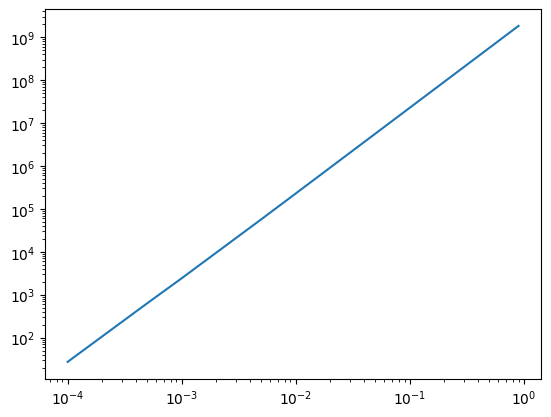

In [ ]:

delta = 1e-5
m_train = X_train.shape[0]
print(m_train, c)
delta_cap = (2 * c) / m_train

sigma = sensitivity_calc(epsilon, delta, delta_cap)
print(f"Epsilon: {epsilon}, delta: {delta}, Capital delta: {delta_cap}")
print(f"sigma: {sigma}")

alp_opt = 1 + np.sqrt(2 * sigma**2 * np.log(1 / delta) / epoch)

print(alp_opt)

eps_overall = (epoch * alp_opt / (2 * sigma**2)) + np.log(1 / delta) / (alpha - 1)

print(eps_overall)

plt.plot(epsilon, eps_overall)
plt.xscale('log')
plt.yscale('log')

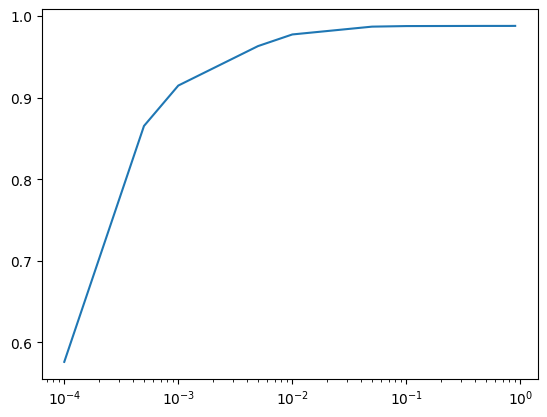

In [ ]:
plt.plot(epsilon, train_hist[:,-1])
plt.xscale('log')

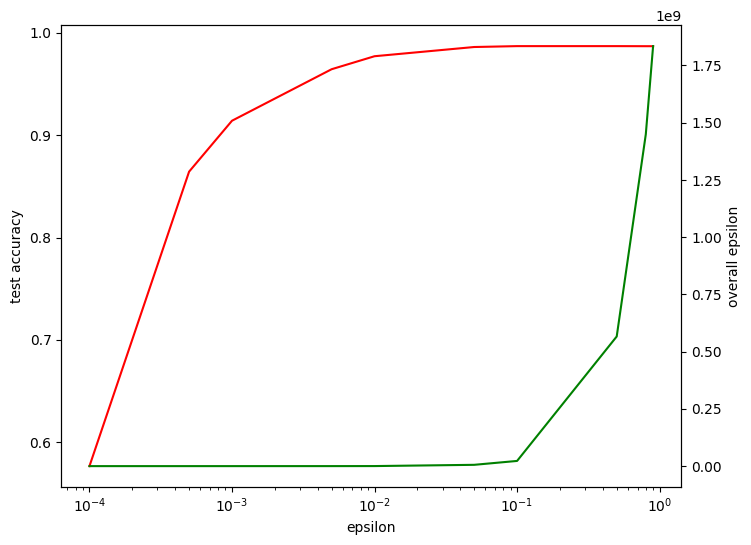

In [ ]:
fig, ax1 = plt.subplots(figsize = (8,6))
ax2 = ax1.twinx()
ax1.plot(epsilon, test_hist[:,-1], 'r')
ax1.set(xlabel = 'epsilon', ylabel = 'test accuracy')
ax2.plot(epsilon, eps_overall, 'g')
ax2.set(ylabel = 'overall epsilon')
plt.xscale('log')